In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_about'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5518016527546408 	 Validation loss: 0.4031345121941324 	 
  1%|          | 574/57400 [01:44<2:47:08,  5.67it/s]
Epoch 2 	 Training loss: 0.40072787358370393 	 Validation loss: 0.35901394865270386 	 
  2%|▏         | 1148/57400 [03:36<2:45:19,  5.67it/s]
Epoch 3 	 Training loss: 0.3672026494706134 	 Validation loss: 0.34120332664352354 	 
  3%|▎         | 1722/57400 [05:28<2:40:17,  5.79it/s]
Epoch 4 	 Training loss: 0.34788537619940496 	 Validation loss: 0.3278067463030249 	 
  4%|▍         | 2296/57400 [07:19<3:07:06,  4.91it/s]
Epoch 5 	 Training loss: 0.3350301102738347 	 Validation loss: 0.31915991185075143 	 
  5%|▌         | 2870/57400 [09:09<2:30:37,  6.03it/s]
Epoch 6 	 Training loss: 0.32365512367636484 	 Validation loss: 0.31546387379452334 	 
  6%|▌         | 3444/57400 [11:00<2:45:02,  5.45it/s]
Epoch 7 	 Training loss: 0.31487729280979376 	 Validation loss: 0.3125719536664122 	 
  7%|▋         | 4018/57400 [12:51<2:21:21,  6.29it/s]
Epoch 8 	 Tra

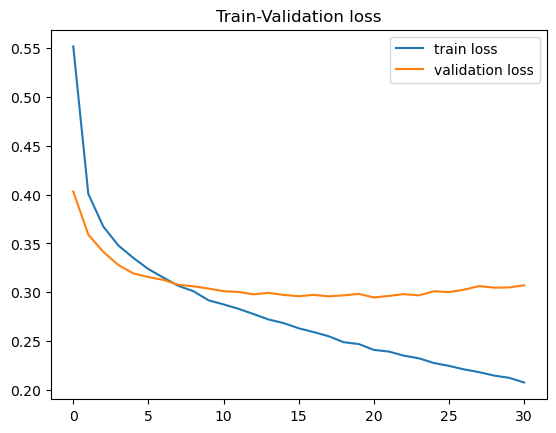

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8596938775510204, 'precision': 0.8596938775510204, 'f1': 0.8596938775510204, 'accuracy': 0.8596938775510204}
MALE {'recall': 0.8697916666666666, 'precision': 0.8697916666666666, 'f1': 0.8697916666666666, 'accuracy': 0.8697916666666666}
FEMALE {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7121212121212122, 'precision': 0.7121212121212122, 'f1': 0.7121212121212122, 'accuracy': 0.7121212121212122}
MALE {'recall': 0.7299270072992701, 'precision': 0.7299270072992701, 'f1': 0.72992700729927, 'accuracy': 0.7299270072992701}
FEMALE {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6923076923076923, 'precision': 0.6923076923076923, 'f1': 0.6923076923076923, 'accuracy': 0.6923076923076923}
MALE {'recall': 0.71464646

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.54284923588565 	 Validation loss: 0.3897216754444575 	 
  1%|          | 574/57400 [01:41<2:23:16,  6.61it/s]
Epoch 2 	 Training loss: 0.3944528518238134 	 Validation loss: 0.3506275203268407 	 
  2%|▏         | 1148/57400 [03:23<2:32:16,  6.16it/s]
Epoch 3 	 Training loss: 0.36241991942560214 	 Validation loss: 0.3330098014261763 	 
  3%|▎         | 1722/57400 [05:04<2:54:19,  5.32it/s]
Epoch 4 	 Training loss: 0.34517181446639505 	 Validation loss: 0.32337234762765593 	 
  4%|▍         | 2296/57400 [06:46<2:40:44,  5.71it/s]
Epoch 5 	 Training loss: 0.33395281916919073 	 Validation loss: 0.31502860052100684 	 
  5%|▌         | 2870/57400 [08:27<2:25:59,  6.23it/s]
Epoch 6 	 Training loss: 0.32081370899382367 	 Validation loss: 0.3079276936034025 	 
  6%|▌         | 3444/57400 [10:08<2:25:50,  6.17it/s]
Epoch 7 	 Training loss: 0.31412457168517627 	 Validation loss: 0.306518829980139 	 
  7%|▋         | 4018/57400 [11:50<2:31:13,  5.88it/s]
Epoch 8 	 Trainin

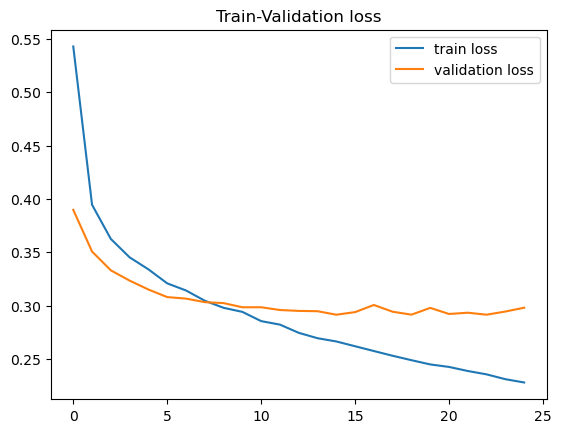

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8584183673469388, 'precision': 0.8584183673469388, 'f1': 0.8584183673469388, 'accuracy': 0.8584183673469388}
MALE {'recall': 0.8671875, 'precision': 0.8671875, 'f1': 0.8671875, 'accuracy': 0.8671875}
FEMALE {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7032828282828283, 'precision': 0.7032828282828283, 'f1': 0.7032828282828283, 'accuracy': 0.7032828282828283}
MALE {'recall': 0.7153284671532847, 'precision': 0.7153284671532847, 'f1': 0.7153284671532847, 'accuracy': 0.7153284671532847}
FEMALE {'recall': 0.6902887139107612, 'precision': 0.6902887139107612, 'f1': 0.6902887139107612, 'accuracy': 0.6902887139107612} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6949152542372882, 'precision': 0.6949152542372882, 'f1': 0.6949152542372882, 'accuracy': 0.6949152542372882}
MALE {'recall': 0.7171717171717171, 'precision': 0.717171717

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5648708150881093 	 Validation loss: 0.4046601658150301 	 
  1%|          | 574/57400 [01:42<2:38:06,  5.99it/s]
Epoch 2 	 Training loss: 0.402180323669304 	 Validation loss: 0.35855468400454116 	 
  2%|▏         | 1148/57400 [03:24<2:35:03,  6.05it/s]
Epoch 3 	 Training loss: 0.3667740677240003 	 Validation loss: 0.3373313483040212 	 
  3%|▎         | 1722/57400 [05:07<2:37:23,  5.90it/s]
Epoch 4 	 Training loss: 0.3489165465746607 	 Validation loss: 0.32742524323827127 	 
  4%|▍         | 2296/57400 [06:49<2:38:17,  5.80it/s]
Epoch 5 	 Training loss: 0.3343700178045429 	 Validation loss: 0.32132330536842346 	 
  5%|▌         | 2870/57400 [08:30<2:27:29,  6.16it/s]
Epoch 6 	 Training loss: 0.3235205996275364 	 Validation loss: 0.31467463025602244 	 
  6%|▌         | 3444/57400 [10:12<2:37:03,  5.73it/s]
Epoch 7 	 Training loss: 0.3148562645714873 	 Validation loss: 0.3096067784196239 	 
  7%|▋         | 4018/57400 [11:53<2:41:52,  5.50it/s]
Epoch 8 	 Training

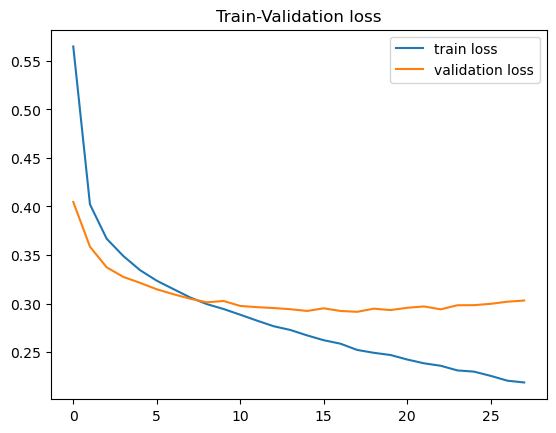

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8622448979591837, 'precision': 0.8622448979591837, 'f1': 0.8622448979591837, 'accuracy': 0.8622448979591837}
MALE {'recall': 0.875, 'precision': 0.875, 'f1': 0.875, 'accuracy': 0.875}
FEMALE {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.702020202020202, 'precision': 0.702020202020202, 'f1': 0.702020202020202, 'accuracy': 0.702020202020202}
MALE {'recall': 0.7177615571776156, 'precision': 0.7177615571776156, 'f1': 0.7177615571776156, 'accuracy': 0.7177615571776156}
FEMALE {'recall': 0.6850393700787402, 'precision': 0.6850393700787402, 'f1': 0.6850393700787402, 'accuracy': 0.6850393700787402} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6923076923076923, 'precision': 0.6923076923076923, 'f1': 0.6923076923076923, 'accuracy': 0.6923076923076923}
MALE {'recall': 0.7171717171717171, 'precision': 0.7171717171717171, 'f1': 0.717

Resultados finales

In [23]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8601190476190477, 'precision': 0.8601190476190477, 'f1': 0.8601190476190477, 'accuracy': 0.8601190476190477}
Métricas etiqueta male: {'recall': 0.8706597222222222, 'precision': 0.8706597222222222, 'f1': 0.8706597222222222, 'accuracy': 0.8706597222222222}
Métricas etiqueta female:  {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85}

 to
Resultado global: {'recall': 0.7058080808080808, 'precision': 0.7058080808080808, 'f1': 0.7058080808080808, 'accuracy': 0.7058080808080808}
Métricas etiqueta male: {'recall': 0.7210056772100568, 'precision': 0.7210056772100568, 'f1': 0.7210056772100567, 'accuracy': 0.7210056772100568}
Métricas etiqueta female:  {'recall': 0.689413823272091, 'precision': 0.689413823272091, 'f1': 0.689413823272091, 'accuracy': 0.689413823272091}

 as
Resultado global: {'recall': 0.6931768796175576, 'precision': 0.6931768796175576, 'f1': 0.6931768796175576, 'accuracy': 0.6931768796175576}
Métricas et

# TO

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948064472201809 	 Validation loss: 0.6922508993391263 	 
  1%|          | 574/57400 [01:51<2:50:41,  5.55it/s]
Epoch 2 	 Training loss: 0.6944559684821537 	 Validation loss: 0.6922130534204386 	 
  2%|▏         | 1148/57400 [03:44<2:47:38,  5.59it/s]
Epoch 3 	 Training loss: 0.6942975693463448 	 Validation loss: 0.6926831421205553 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:37<2:33:31,  6.04it/s]
Epoch 4 	 Training loss: 0.694097380916416 	 Validation loss: 0.6920658875319917 	 
  4%|▍         | 2296/57400 [07:31<2:32:00,  6.04it/s]
Epoch 5 	 Training loss: 0.6943078578972235 	 Validation loss: 0.6922586226867418 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [09:24<2:28:18,  6.13it/s]
Epoch 6 	 Training loss: 0.6944290130603604 	 Validation loss: 0.692675824892723 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [11:17<2:46:25,  5.40it/s]
Epoch 7 	 Training loss: 0.6939855712216075 	 Validation loss: 0.69261119325

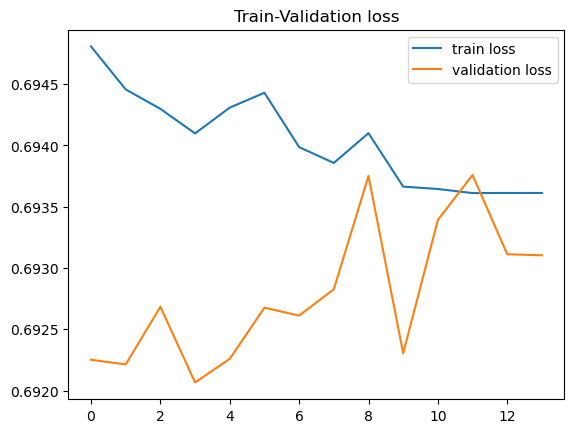

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.036458333333333336, 'precision': 0.036458333333333336, 'f1': 0.036458333333333336, 'accuracy': 0.036458333333333336}
FEMALE {'recall': 0.9575, 'precision': 0.9575, 'f1': 0.9575, 'accuracy': 0.9575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48484848484848486, 'precision': 0.48484848484848486, 'f1': 0.48484848484848486, 'accuracy': 0.48484848484848486}
MALE {'recall': 0.024330900243309004, 'precision': 0.024330900243309004, 'f1': 0.024330900243309004, 'accuracy': 0.024330900243309004}
FEMALE {'recall': 0.9816272965879265, 'precision': 0.9816272965879265, 'f1': 0.9816272965879265, 'accuracy': 0.9816272965879265} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.47979139504563234, 'precision': 0.47979139504563234, 'f1': 0.47979139504563234, 'accuracy': 0.47979139504

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6945534295529023 	 Validation loss: 0.6941576943559161 	 
  1%|          | 574/57400 [01:44<2:34:18,  6.14it/s]
Epoch 2 	 Training loss: 0.6941143633596573 	 Validation loss: 0.6939157873897229 	 
  2%|▏         | 1148/57400 [03:28<2:40:46,  5.83it/s]
Epoch 3 	 Training loss: 0.6939893649430225 	 Validation loss: 0.6933603276640682 	 
  3%|▎         | 1722/57400 [05:12<2:29:08,  6.22it/s]
Epoch 4 	 Training loss: 0.6941018343387165 	 Validation loss: 0.6930071176108668 	 
  4%|▍         | 2296/57400 [06:57<2:22:53,  6.43it/s]
Epoch 5 	 Training loss: 0.6937249422281045 	 Validation loss: 0.6932633963681883 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:40<3:18:20,  4.58it/s]
Epoch 6 	 Training loss: 0.6935503764227292 	 Validation loss: 0.6923180475073346 	 
  6%|▌         | 3444/57400 [10:25<2:29:32,  6.01it/s]
Epoch 7 	 Training loss: 0.6937072035119924 	 Validation loss: 0.6933670478352045 	 

1 epoch without improvement
  7%|▋         | 4

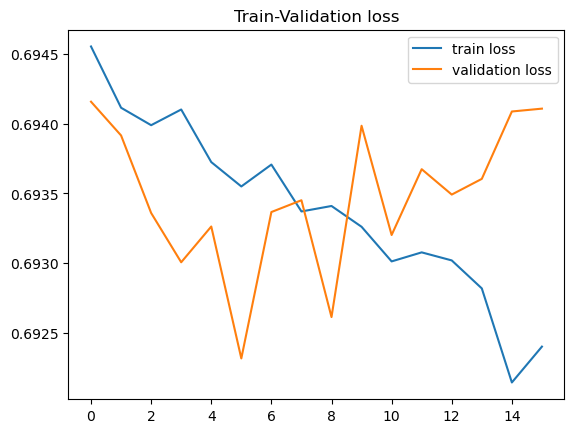

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5548469387755102, 'precision': 0.5548469387755102, 'f1': 0.5548469387755102, 'accuracy': 0.5548469387755102}
MALE {'recall': 0.20833333333333334, 'precision': 0.20833333333333334, 'f1': 0.20833333333333334, 'accuracy': 0.20833333333333334}
FEMALE {'recall': 0.8875, 'precision': 0.8875, 'f1': 0.8875, 'accuracy': 0.8875} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5378787878787878, 'precision': 0.5378787878787878, 'f1': 0.5378787878787878, 'accuracy': 0.5378787878787878}
MALE {'recall': 0.21654501216545013, 'precision': 0.21654501216545013, 'f1': 0.21654501216545013, 'accuracy': 0.21654501216545013}
FEMALE {'recall': 0.884514435695538, 'precision': 0.884514435695538, 'f1': 0.884514435695538, 'accuracy': 0.884514435695538} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5332464146023468, 'precision': 0.5332464146023468, 'f1': 0.5332464146023468, 'accuracy': 0.5332464146023468}
MALE {'recal

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6970137250755722 	 Validation loss: 0.6918144165459326 	 
  1%|          | 574/57400 [01:44<2:22:37,  6.64it/s]
Epoch 2 	 Training loss: 0.6952144910649556 	 Validation loss: 0.6933237910270691 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:28<2:40:08,  5.85it/s]
Epoch 3 	 Training loss: 0.6949672136157232 	 Validation loss: 0.6929464562464569 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:12<2:22:06,  6.53it/s]
Epoch 4 	 Training loss: 0.6948969771222371 	 Validation loss: 0.6929401027954231 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [06:55<2:20:16,  6.55it/s]
Epoch 5 	 Training loss: 0.6946359699403782 	 Validation loss: 0.6927243632785345 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [08:40<2:37:21,  5.78it/s]
Epoch 6 	 Training loss: 0.6944997847495594 	 Validation loss: 0.6933651627120325 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [10:23<2:36:16,  5.75it/s]
Epoch 7 	 Traini

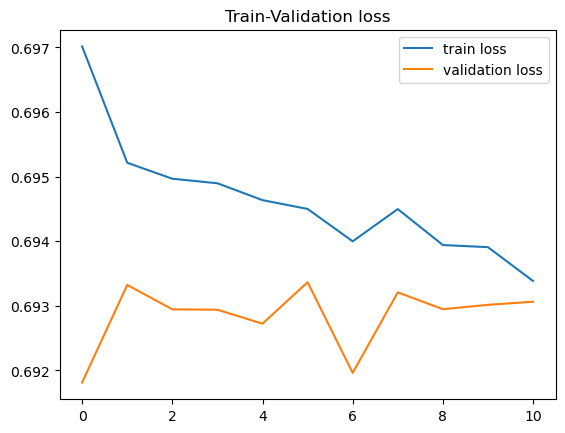

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5127551020408163, 'precision': 0.5127551020408163, 'f1': 0.5127551020408163, 'accuracy': 0.5127551020408163}
MALE {'recall': 0.0234375, 'precision': 0.0234375, 'f1': 0.0234375, 'accuracy': 0.0234375}
FEMALE {'recall': 0.9825, 'precision': 0.9825, 'f1': 0.9825, 'accuracy': 0.9825} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.019464720194647202, 'precision': 0.019464720194647202, 'f1': 0.019464720194647202, 'accuracy': 0.019464720194647202}
FEMALE {'recall': 0.979002624671916, 'precision': 0.979002624671916, 'f1': 0.979002624671916, 'accuracy': 0.979002624671916} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.485006518904824, 'precision': 0.485006518904824, 'f1': 0.485006518904824, 'accuracy': 0.485006518904824}
MALE {'recall': 0.022727272727272728, 'precision': 0

Resultados finales

In [22]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5246598639455782, 'precision': 0.5246598639455782, 'f1': 0.5246598639455782, 'accuracy': 0.5246598639455782}
Métricas etiqueta male: {'recall': 0.08940972222222222, 'precision': 0.08940972222222222, 'f1': 0.08940972222222222, 'accuracy': 0.08940972222222222}
Métricas etiqueta female:  {'recall': 0.9425, 'precision': 0.9425, 'f1': 0.9425, 'accuracy': 0.9425}

 to
Resultado global: {'recall': 0.5012626262626263, 'precision': 0.5012626262626263, 'f1': 0.5012626262626263, 'accuracy': 0.5012626262626263}
Métricas etiqueta male: {'recall': 0.08678021086780212, 'precision': 0.08678021086780212, 'f1': 0.08678021086780212, 'accuracy': 0.08678021086780212}
Métricas etiqueta female:  {'recall': 0.9483814523184602, 'precision': 0.9483814523184602, 'f1': 0.9483814523184602, 'accuracy': 0.9483814523184602}

 as
Resultado global: {'recall': 0.49934810951760106, 'precision': 0.49934810951760106, 'f1': 0.49934810951760106, 'accuracy': 0.499348

# AS

In [15]:
learning_rate = 1e-6
num_epochs = 100
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.694101590831936 	 Validation loss: 0.6931723437066806 	 
  1%|          | 574/57400 [01:44<2:33:12,  6.18it/s]
Epoch 2 	 Training loss: 0.6934127430674921 	 Validation loss: 0.6931961986978176 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:29<2:44:39,  5.69it/s]
Epoch 3 	 Training loss: 0.6902037291992001 	 Validation loss: 0.6921123043965485 	 
  3%|▎         | 1722/57400 [05:13<2:37:50,  5.88it/s]
Epoch 4 	 Training loss: 0.6878948425582062 	 Validation loss: 0.6887050048779633 	 
  4%|▍         | 2296/57400 [06:58<2:21:19,  6.50it/s]
Epoch 5 	 Training loss: 0.6856461252485003 	 Validation loss: 0.6929555111012217 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:42<2:17:50,  6.59it/s]
Epoch 6 	 Training loss: 0.6840859804211593 	 Validation loss: 0.6888745245286974 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:26<2:37:28,  5.71it/s]
Epoch 7 	 Training loss: 0.6825352671462069 	 Validation loss: 0.6903003979

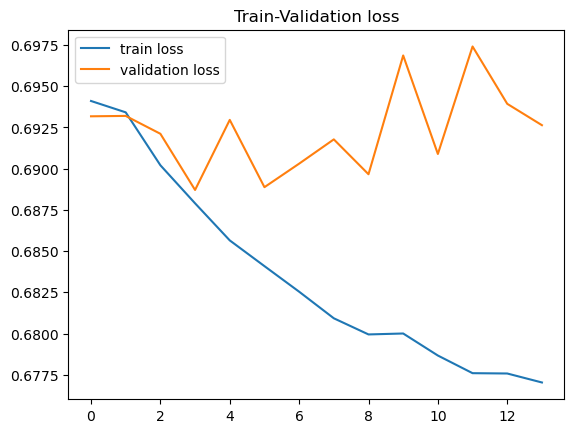

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('roberta_brk_as'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6683673469387755, 'precision': 0.6683673469387755, 'f1': 0.6683673469387755, 'accuracy': 0.6683673469387755}
MALE {'recall': 0.71875, 'precision': 0.71875, 'f1': 0.71875, 'accuracy': 0.71875}
FEMALE {'recall': 0.62, 'precision': 0.62, 'f1': 0.62, 'accuracy': 0.62} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6755050505050505, 'precision': 0.6755050505050505, 'f1': 0.6755050505050505, 'accuracy': 0.6755050505050505}
MALE {'recall': 0.7737226277372263, 'precision': 0.7737226277372263, 'f1': 0.7737226277372263, 'accuracy': 0.7737226277372263}
FEMALE {'recall': 0.5695538057742782, 'precision': 0.5695538057742782, 'f1': 0.5695538057742782, 'accuracy': 0.5695538057742782} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7561929595827901, 'precision': 0.7561929595827901, 'f1': 0.7561929595827901, 'accuracy': 0.7561929595827901}
MALE {'recall': 0.73989898989899, 'precision': 0.73989898989899, 'f1

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940974201682553 	 Validation loss: 0.6933874730336465 	 
  1%|          | 574/57400 [01:37<2:30:26,  6.30it/s]
Epoch 2 	 Training loss: 0.6936723436212706 	 Validation loss: 0.6916656878034947 	 
  2%|▏         | 1148/57400 [03:17<2:46:48,  5.62it/s]
Epoch 3 	 Training loss: 0.6930697510466758 	 Validation loss: 0.6918447330846624 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:55<2:26:03,  6.35it/s]
Epoch 4 	 Training loss: 0.6912448613901172 	 Validation loss: 0.6917759149761523 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:33<2:13:53,  6.86it/s]
Epoch 5 	 Training loss: 0.6890672991500083 	 Validation loss: 0.6893829188104403 	 
  5%|▌         | 2870/57400 [08:17<2:29:14,  6.09it/s]
Epoch 6 	 Training loss: 0.6863387103487806 	 Validation loss: 0.6908849023156247 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:57<2:26:42,  6.13it/s]
Epoch 7 	 Training loss: 0.6851384737350384 	 Validation loss: 0.692967952

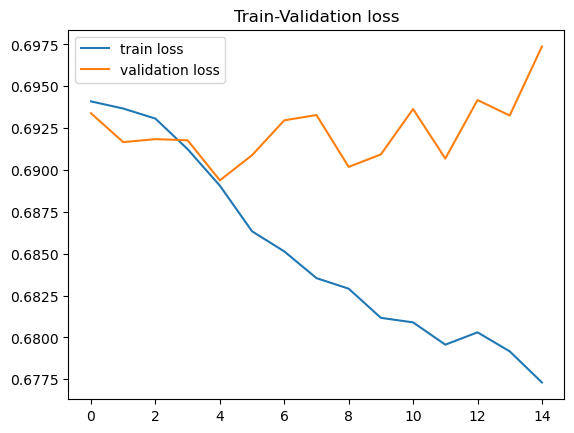

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6683673469387755, 'precision': 0.6683673469387755, 'f1': 0.6683673469387755, 'accuracy': 0.6683673469387755}
MALE {'recall': 0.4791666666666667, 'precision': 0.4791666666666667, 'f1': 0.4791666666666667, 'accuracy': 0.4791666666666667}
FEMALE {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.672979797979798, 'precision': 0.672979797979798, 'f1': 0.672979797979798, 'accuracy': 0.672979797979798}
MALE {'recall': 0.5231143552311436, 'precision': 0.5231143552311436, 'f1': 0.5231143552311436, 'accuracy': 0.5231143552311436}
FEMALE {'recall': 0.8346456692913385, 'precision': 0.8346456692913385, 'f1': 0.8346456692913384, 'accuracy': 0.8346456692913385} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6675358539765319, 'precision': 0.6675358539765319, 'f1': 0.6675358539765319, 'accuracy': 0.6675358539765319}
MALE {'recall': 0.4520202020

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6953224197081987 	 Validation loss: 0.6922047653440702 	 
  1%|          | 574/57400 [01:36<2:36:56,  6.03it/s]
Epoch 2 	 Training loss: 0.6939700133709127 	 Validation loss: 0.6925746354006105 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:13<2:26:36,  6.39it/s]
Epoch 3 	 Training loss: 0.6920518042318496 	 Validation loss: 0.6925315452834307 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:48<2:07:51,  7.26it/s]
Epoch 4 	 Training loss: 0.688700455821765 	 Validation loss: 0.6911663008948504 	 
  4%|▍         | 2296/57400 [06:25<2:27:12,  6.24it/s]
Epoch 5 	 Training loss: 0.6878254614017566 	 Validation loss: 0.6902609366481587 	 
  5%|▌         | 2870/57400 [08:03<2:36:34,  5.80it/s]
Epoch 6 	 Training loss: 0.6862954506683018 	 Validation loss: 0.690201311798419 	 
  6%|▌         | 3444/57400 [09:40<2:16:30,  6.59it/s]
Epoch 7 	 Training loss: 0.6851531294164758 	 Validation loss: 0.6895114132913492 	 
  7%|▋         | 401

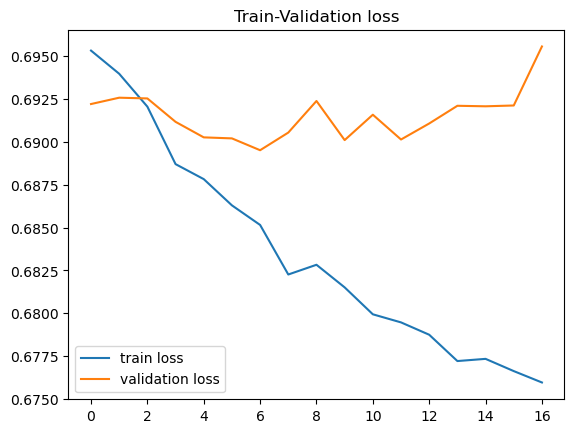

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_brk_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6696428571428571, 'precision': 0.6696428571428571, 'f1': 0.6696428571428571, 'accuracy': 0.6696428571428571}
MALE {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}
FEMALE {'recall': 0.6725, 'precision': 0.6725, 'f1': 0.6725, 'accuracy': 0.6725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7487373737373737, 'precision': 0.7487373737373737, 'f1': 0.7487373737373737, 'accuracy': 0.7487373737373737}
MALE {'recall': 0.7737226277372263, 'precision': 0.7737226277372263, 'f1': 0.7737226277372263, 'accuracy': 0.7737226277372263}
FEMALE {'recall': 0.7217847769028871, 'precision': 0.7217847769028871, 'f1': 0.7217847769028871, 'accuracy': 0.7217847769028871} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.8044328552803129, 'precision': 0.8044328552803129, 'f1': 0.8044328552803129, 'accuracy': 0.8044328552803129}
MALE {'recall': 

Resultados finales

In [22]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6687925170068028, 'precision': 0.6687925170068028, 'f1': 0.6687925170068028, 'accuracy': 0.6687925170068028}
Métricas etiqueta male: {'recall': 0.6215277777777778, 'precision': 0.6215277777777778, 'f1': 0.6215277777777778, 'accuracy': 0.6215277777777778}
Métricas etiqueta female:  {'recall': 0.7141666666666666, 'precision': 0.7141666666666666, 'f1': 0.7141666666666666, 'accuracy': 0.7141666666666666}

 to
Resultado global: {'recall': 0.6990740740740741, 'precision': 0.6990740740740741, 'f1': 0.6990740740740741, 'accuracy': 0.6990740740740741}
Métricas etiqueta male: {'recall': 0.6901865369018654, 'precision': 0.6901865369018654, 'f1': 0.6901865369018654, 'accuracy': 0.6901865369018654}
Métricas etiqueta female:  {'recall': 0.7086614173228346, 'precision': 0.7086614173228346, 'f1': 0.7086614173228346, 'accuracy': 0.7086614173228346}

 as
Resultado global: {'recall': 0.7427205562798783, 'precision': 0.7427205562798783, 'f1': 0.7